In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Softmax, Input,
                          BatchNormalization, multiply, Activation, Add, Lambda, Dropout, Flatten)
from tensorflow.keras import activations
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from skimage.color import rgb2gray, gray2rgb
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("x_ray/labels_x_ray.csv")
bad_files = os.listdir("x_ray/bad")
bad_files = [f for f in bad_files if (".jpg" in f) or (".png" in f)]

filtered_df = df[~df['image_Addr'].isin(bad_files)].drop_duplicates()

datadir = "new_x_ray"
num_classes = 5 
filtered_df[['label_image']] = filtered_df[['label_image']] - 1
img_size = 224
batch_size = 32
target_size = (img_size, img_size)
print(df.columns)
filtered_df['label_image'] = filtered_df['label_image'].apply(str)

train_files, valid_files = train_test_split(filtered_df['image_Addr'],
                                            test_size=0.25,
                                            random_state=2024,
                                            stratify=filtered_df['label_image'])

train_df = filtered_df[filtered_df['image_Addr'].isin(train_files)]
valid_df = filtered_df[filtered_df['image_Addr'].isin(valid_files)]
print(f"Validation Size = {valid_df.shape[0]}, Train Size = {train_df.shape[0]}")

label_decoding = {0: "Dandan", 1: "JomJome", 2: "Sine", 3: "Dast", 4: "Pa"}

model = tf.keras.models.load_model("output/vgg16-0.96-full_model.h5")


def predict_score(img, model):
    score = model.predict(img)
    return score

def load_and_process(img, dir):
    img = Image.open(os.path.join(dir, img))
    img = img.convert('L')
    img = img.convert('RGB')
    img = img.resize(target_size)
    img = np.array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    return img

Index(['image_Addr', 'label_image'], dtype='object')
Validation Size = 142, Train Size = 424


C:\Users\Atlas\anaconda3\envs\golgohar\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


=== Metrics ===
auroc      0.891454
fpr95tpr   0.366197

=== Plots ===
Threshold = -0.9959281772375107


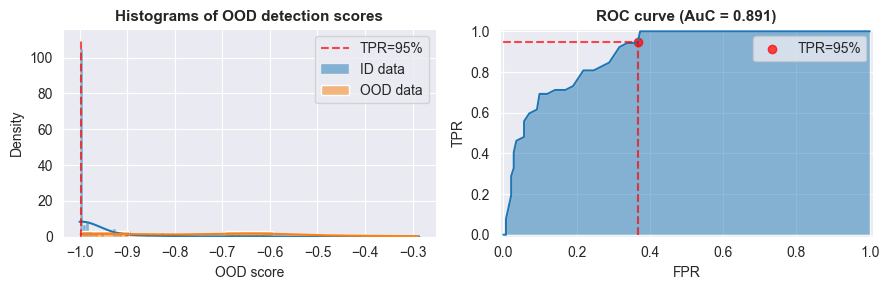

In [3]:
from oodeel.methods import MLS
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features

mls = MLS(output_activation="softmax")
mls.fit(model)
images = np.zeros((len(valid_df), img_size, img_size, 3))
for i, f in enumerate(valid_df.image_Addr):
    img_file = load_and_process(f, "x_ray")
    images[i] = img_file[0]
scores_in, _ = mls.score(images)


images = np.zeros((len(bad_files), img_size, img_size, 3))
for i, f in enumerate(bad_files):
    img_file = load_and_process(f, "x_ray/bad")
    images[i] = img_file[0]
scores_out, _ = mls.score(images)    

metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
print(f"Threshold = {np.percentile(scores_out, q=5.0)}")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

C:\Users\Atlas\anaconda3\envs\golgohar\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


=== Metrics ===
auroc      0.961268
fpr95tpr   0.098592

=== Plots ===
Threshold = -0.8853905200958252


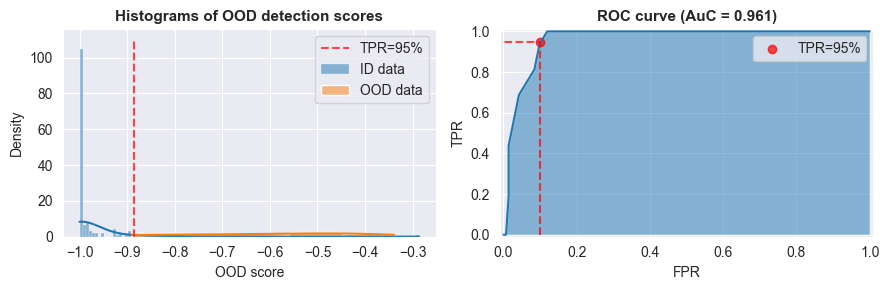

In [4]:
mls = MLS(output_activation="softmax")
mls.fit(model)
images = np.zeros((len(valid_df), img_size, img_size, 3))
for i, f in enumerate(valid_df.image_Addr):
    img_file = load_and_process(f, "x_ray")
    images[i] = img_file[0]
scores_in, _ = mls.score(images)

ood_files = os.listdir("ood_data")
images = np.zeros((len(ood_files), img_size, img_size, 3))
for i, f in enumerate(ood_files):
    img_file = load_and_process(f, "ood_data")
    images[i] = img_file[0]
scores_out, _ = mls.score(images)

metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
print(f"Threshold = {np.percentile(scores_out, q=5.0)}")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()